# 목표
Matrix Factorization Techniques for Recommender Systems [https://ieeexplore.ieee.org/abstract/document/5197422]  
위 논문에서 사용하는 Matrix Factorization을 Keras를 통해 구현한다. (~Bias)

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

plt.style.use('bmh')

# Load Dataset

Kaggle의 The Movies Dataset : https://www.kaggle.com/rounakbanik/the-movies-dataset  
이 중에서 `rating_small.csv`를 사용한다.

In [2]:
def load_dataset():

    df = pd.read_csv('ratings_small.csv')

    X = df[['userId', 'movieId']].to_numpy(dtype=np.int64)
    y = df[['rating']].to_numpy(dtype=np.float32)

    # 유저의 인덱스를 0부터 세어주기 위해
    X[:, 0] -= 1

    # 중간중간 건너뛰는 영화 ID를 해당하는 인덱스로 매핑한다.
    mid2idx = dict((mid, i) for i, mid in enumerate(np.unique(X[:, 1])))
    X[:, 1] = [mid2idx[mid] for mid in X[:, 1]]

    # 라벨의 쉐이프를 1로
    y = y.reshape([-1])

    return X, y

X, y = load_dataset()

In [3]:
num_users = len(np.unique(X[:, 0]))
num_movies = len(np.unique(X[:, 1]))

print(f"Number of users: {num_users}, number of movies: {num_movies}")
print(f"Total number of ratings: {len(X)}")
print(f"Sparsity Level: {1 - len(X) / (num_users * num_movies):.4f}")

Number of users: 671, number of movies: 9066
Total number of ratings: 100004
Sparsity Level: 0.9836


In [4]:
from sklearn.model_selection import train_test_split

# 총 데이터셋을 학습 / 검증 / 평가 세트로 나눠준다. (8:1:1 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=24)

# Case 1: Plain Matrix Factorization

* estimated rating for user $u$ to item $i$ : $\hat{r}_{ui} = q_i^Tp_u$
* objective function : $\displaystyle\min_{q^*,p^*} \sum_{(u,i)\in \kappa} (r_{ui}-q_i^Tp_u)^2$

In [5]:
class MatrixFactorization(tf.keras.Model):

    def __init__(self, n_users, n_items, n_factors):
        super(MatrixFactorization, self).__init__()

        initializer = tf.random_normal_initializer()
        self.user_fvec = tf.Variable(initializer([n_users, n_factors]))  # user_id latent factor vectors
        self.item_fvec = tf.Variable(initializer([n_factors, n_items]))  # item_id latent factor vectors
    
    def call(self, inputs):
        # 두 매트릭스를 dot 연산 후 inputs으로부터 해당하는 인덱스의 값들을 예측치로 반환한다.
        mat = tf.matmul(self.user_fvec, self.item_fvec)
        return tf.gather_nd(mat, inputs)

## Unit Test

In [6]:
model = MatrixFactorization(num_users, num_movies, n_factors=80)
model.compile(optimizer='adam', loss=['mse'], metrics=['mae'])

h = model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=1, validation_data=(X_valid, y_valid), shuffle=True)

Epoch 1/20
1251/1251 [==============================] - 4s 3ms/step - loss: 13.3592 - mae: 3.4955 - val_loss: 5.8081 - val_mae: 2.1081
Epoch 2/20
1251/1251 [==============================] - 3s 3ms/step - loss: 3.6631 - mae: 1.5593 - val_loss: 1.8477 - val_mae: 1.0094
Epoch 3/20
1251/1251 [==============================] - 3s 3ms/step - loss: 1.2497 - mae: 0.8441 - val_loss: 1.4072 - val_mae: 0.8618
Epoch 4/20
1251/1251 [==============================] - 3s 3ms/step - loss: 0.7929 - mae: 0.6784 - val_loss: 1.2995 - val_mae: 0.8255
Epoch 5/20
1251/1251 [==============================] - 3s 3ms/step - loss: 0.5906 - mae: 0.5845 - val_loss: 1.2632 - val_mae: 0.8123
Epoch 6/20
1251/1251 [==============================] - 3s 3ms/step - loss: 0.4560 - mae: 0.5092 - val_loss: 1.2607 - val_mae: 0.8144
Epoch 7/20
1251/1251 [==============================] - 3s 3ms/step - loss: 0.3546 - mae: 0.4451 - val_loss: 1.2688 - val_mae: 0.8157
Epoch 8/20
1251/1251 [==============================] - 3s 3m

In [7]:
y_pred = model.predict(X_test)
mae = tf.keras.losses.mae(y_test, y_pred)
print('test_MAE:', mae.numpy())

test_MAE: 0.88459


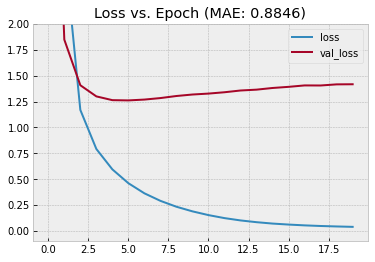

In [8]:
plt.figure()
plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val_loss')
plt.title(f"Loss vs. Epoch (MAE: {mae:.4f})")
plt.ylim(-0.1, 2.0)
plt.legend()
plt.show()

## Grid Search

In [9]:
import time
hist = {}

n_factors = [20, 80, 120]
for n_factors in n_factors:
    model = MatrixFactorization(num_users, num_movies, n_factors)
    model.compile(optimizer='adam', loss=['mse'], metrics=['mae'])
    
    init = time.time()
    h = model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=0, validation_data=(X_valid, y_valid), shuffle=True)
    learning_time = time.time() - init
    
    y_pred = model.predict(X_test)
    result = tf.keras.metrics.MAE(y_test, y_pred)
    
    hist[f'n_factors={n_factors} (MAE: {result:.3f})'] = h
    
    print(f"n_factors={n_factors}\t test_MAE: {result:.3f}, learning_time: {learning_time:.4f}")

n_factors=20	 test_MAE: 0.813, learning_time: 41.6295
n_factors=80	 test_MAE: 0.880, learning_time: 44.8540
n_factors=120	 test_MAE: 0.859, learning_time: 46.1446


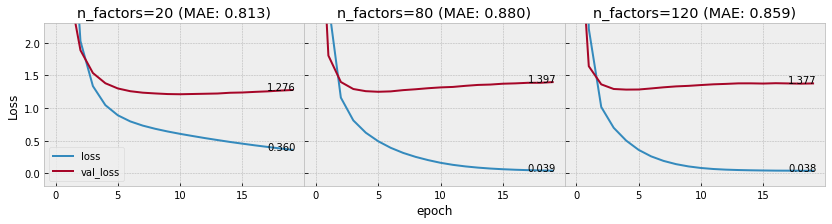

In [10]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(14,3))
for i, (k, v) in enumerate(hist.items()):
    axes[i].plot(v.history['loss'])
    axes[i].plot(v.history['val_loss'])
    axes[i].set_title(k)
    axes[i].text(17, v.history['loss'][-1], f"{v.history['loss'][-1]:.3f}")
    axes[i].text(17, v.history['val_loss'][-1], f"{v.history['val_loss'][-1]:.3f}")
plt.subplots_adjust(wspace=0, hspace=0)
plt.ylim((-0.2, 2.3))
axes[0].legend(['loss', 'val_loss'], loc='lower left')
axes[1].set_xlabel('epoch')
axes[0].set_ylabel('Loss')
plt.show()

# Case 2: Matrix Factorization with Bias

* bias term involved in rating $r_{ui}$ : $b_{ui}=\mu + b_u + b_i$, where $\mu$ is overral average
* estimated rating for user $u$ to item $i$ : $\hat{r}_{ui} = \mu + b_u + b_i + q_i^Tp_u$
* objective function : $\displaystyle\min_{q^*,p^*} \sum_{(u,i)\in \kappa} (r_{ui}-\mu-b_u-b_i-q_i^Tp_u)^2$

In [11]:
class MatrixFactorization(tf.keras.Model):

    def __init__(self, n_users, n_items, n_factors, mu):
        super(MatrixFactorization, self).__init__()
        
        initializer = tf.random_normal_initializer()
        self.user_fvec = tf.Variable(initializer([n_users, n_factors]))  # user_id latent factor vectors
        self.item_fvec = tf.Variable(initializer([n_factors, n_items]))  # item_id latent factor vectors
        
        self.user_bias = tf.Variable(initializer([n_users]))
        self.item_bias = tf.Variable(initializer([n_items]))
        
        self.mu = float(mu)  # overall average rating
    
    def call(self, inputs):
        mat = tf.matmul(self.user_fvec, self.item_fvec)
        bias = self.mu + tf.gather(self.user_bias, inputs[:, 0]) + tf.gather(self.item_bias, inputs[:, 1])
        return bias + tf.gather_nd(mat, inputs)

## Unit Test

In [12]:
mu = np.mean(y_test)

model = MatrixFactorization(num_users, num_movies, 80, mu)
model.compile(optimizer='adam', loss=['mse'], metrics=['mae'])

h = model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=1, validation_data=(X_valid, y_valid), shuffle=True)

Epoch 1/20
1251/1251 [==============================] - 4s 3ms/step - loss: 1.0724 - mae: 0.8260 - val_loss: 0.9372 - val_mae: 0.7615
Epoch 2/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.7963 - mae: 0.6901 - val_loss: 0.8088 - val_mae: 0.6921
Epoch 3/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.4776 - mae: 0.5113 - val_loss: 0.7903 - val_mae: 0.6834
Epoch 4/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.2745 - mae: 0.3765 - val_loss: 0.8079 - val_mae: 0.6926
Epoch 5/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.1603 - mae: 0.2814 - val_loss: 0.8324 - val_mae: 0.7045
Epoch 6/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.0989 - mae: 0.2208 - val_loss: 0.8568 - val_mae: 0.7160
Epoch 7/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.0669 - mae: 0.1843 - val_loss: 0.8735 - val_mae: 0.7236
Epoch 8/20
1251/1251 [==============================] - 4s 3ms

In [13]:
y_pred = model.predict(X_test)
mae = tf.keras.losses.mae(y_test, y_pred)
print('test_MAE:', mae.numpy())

test_MAE: 0.7604096


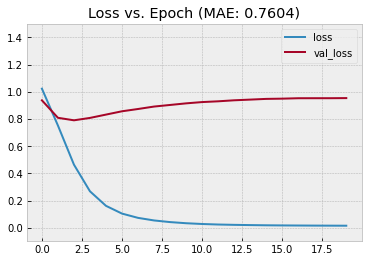

In [14]:
plt.figure()
plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val_loss')
plt.title(f"Loss vs. Epoch (MAE: {mae:.4f})")
plt.ylim(-0.1, 1.5)
plt.legend()
plt.show()

## Grid Search

In [15]:
import time
hist = {}
mu = np.mean(y_test)

n_factors = [20, 80, 120]
for n_factors in n_factors:
    model = MatrixFactorization(num_users, num_movies, n_factors, mu)
    model.compile(optimizer='adam', loss=['mse'], metrics=['mae'])
    
    init = time.time()
    h = model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=0, validation_data=(X_valid, y_valid), shuffle=True)
    learning_time = time.time() - init
    
    y_pred = model.predict(X_test)
    result = tf.keras.metrics.MAE(y_test, y_pred)
    
    hist[f'n_factors={n_factors} (MAE: {result:.3f})'] = h
    
    print(f"n_factors={n_factors}\t test_MAE: {result:.3f}, learning_time: {learning_time:.4f}")

n_factors=20	 test_MAE: 0.795, learning_time: 64.9520
n_factors=80	 test_MAE: 0.760, learning_time: 66.0836
n_factors=120	 test_MAE: 0.718, learning_time: 67.1356


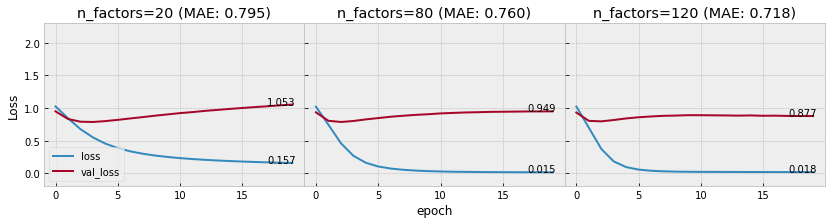

In [16]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(14,3))
for i, (k, v) in enumerate(hist.items()):
    axes[i].plot(v.history['loss'])
    axes[i].plot(v.history['val_loss'])
    axes[i].set_title(k)
    axes[i].text(17, v.history['loss'][-1], f"{v.history['loss'][-1]:.3f}")
    axes[i].text(17, v.history['val_loss'][-1], f"{v.history['val_loss'][-1]:.3f}")
plt.subplots_adjust(wspace=0, hspace=0)
plt.ylim((-0.2, 2.3))
axes[0].legend(['loss', 'val_loss'], loc='lower left')
axes[1].set_xlabel('epoch')
axes[0].set_ylabel('Loss')
plt.show()

# Case 3: Regularized Factorization with Bias

* bias term involved in rating $r_{ui}$ : $b_{ui}=\mu + b_u + b_i$, where $\mu$ is overral average
* estimated rating for user $u$ to item $i$ : $\hat{r}_{ui} = \mu + b_u + b_i + q_i^Tp_u$
* objective function : $\displaystyle\min_{p^*,q^*,b*} \sum_{(u,i)\in \kappa} (r_{ui}-\mu-b_u-b_i-q^T_ip_u)^2+\lambda (\lVert q_i \rVert^2+\lVert p_u \rVert^2 + b_u^2 + b_i^2)$

In [17]:
class MatrixFactorization(tf.keras.Model):

    def __init__(self, n_users, n_items, n_factors, mu, l2=0.1):
        super(MatrixFactorization, self).__init__()
        
        initializer = tf.random_normal_initializer()
        self.user_fvec = tf.Variable(initializer([n_users, n_factors]))  # user_id latent factor vectors
        self.item_fvec = tf.Variable(initializer([n_factors, n_items]))  # item_id latent factor vectors
        
        self.user_bias = tf.Variable(initializer([n_users]))
        self.item_bias = tf.Variable(initializer([n_items]))
        
        self.mu = float(mu)  # overall average rating (train set)
        self.l2 = float(l2)  # extent of regularization
    
    def call(self, inputs):
        # calculate penalty
        user_ss = tf.reduce_sum(tf.square(self.user_fvec), axis=[1])
        item_ss = tf.reduce_sum(tf.square(self.item_fvec), axis=[0])
        
        fvec_penalty = tf.gather(user_ss, inputs[:, 0]) + tf.gather(item_ss, inputs[:, 1])
        
        user_bs = tf.square(self.user_bias)
        item_bs = tf.square(self.item_bias)
        
        bias_penalty = tf.gather(user_bs, inputs[:, 0]) + tf.gather(item_bs, inputs[:, 1])
        
        penalty = tf.reduce_mean(fvec_penalty + bias_penalty)
        self.add_loss(self.l2 * penalty)
        
        mat = tf.matmul(self.user_fvec, self.item_fvec)
        bias = self.mu + tf.gather(self.user_bias, inputs[:, 0]) + tf.gather(self.item_bias, inputs[:, 1])
        return bias + tf.gather_nd(mat, inputs)

## Unit Test

In [18]:
mu = np.mean(y_test)

model = MatrixFactorization(num_users, num_movies, 80, mu, l2=0.1)
model.compile(optimizer='adam', loss=['mse'], metrics=['mae'])

h = model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=1, validation_data=(X_valid, y_valid), shuffle=True)

Epoch 1/20
1251/1251 [==============================] - 5s 3ms/step - loss: 1.1091 - mae: 0.8293 - val_loss: 0.9735 - val_mae: 0.7693
Epoch 2/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.9055 - mae: 0.7295 - val_loss: 0.8952 - val_mae: 0.7025
Epoch 3/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.7846 - mae: 0.6390 - val_loss: 0.8939 - val_mae: 0.6797
Epoch 4/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.7088 - mae: 0.5756 - val_loss: 0.9173 - val_mae: 0.6715
Epoch 5/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.6556 - mae: 0.5245 - val_loss: 0.9415 - val_mae: 0.6678
Epoch 6/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.6269 - mae: 0.4882 - val_loss: 0.9638 - val_mae: 0.6665
Epoch 7/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.5983 - mae: 0.4558 - val_loss: 0.9807 - val_mae: 0.6656
Epoch 8/20
1251/1251 [==============================] - 4s 3ms

In [19]:
y_pred = model.predict(X_test)
mae = tf.keras.losses.mae(y_test, y_pred)
print('test_MAE:', mae.numpy())

test_MAE: 0.66540295


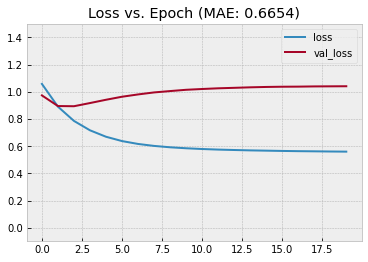

In [20]:
plt.figure()
plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val_loss')
plt.title(f"Loss vs. Epoch (MAE: {mae:.4f})")
plt.ylim(-0.1, 1.5)
plt.legend()
plt.show()

## Grid Search

In [23]:
import time

n_factors = 80
mu = np.mean(y_train)
l2_params = [1000, 100, 10, 1, 0, 0.1, 0.01, 0.001]

hist = {}

for l2 in l2_params:
    model = MatrixFactorization(num_users, num_movies, n_factors, mu, l2)
    model.compile(optimizer='adam', loss=['mse'], metrics=['mae'])
    
    init = time.time()
    h = model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=0, validation_data=(X_valid, y_valid), shuffle=True)
    learning_time = time.time() - init
    
    y_pred = model.predict(X_test)
    result = tf.keras.metrics.MAE(y_test, y_pred)
    
    hist[f'l2={l2} (MAE: {result:.3f})'] = h
    
    print(f"l2({l2})\t test_MAE: {result:.3f}, learning_time: {learning_time:.4f}")

l2(1000)	 test_MAE: 0.839, learning_time: 66.7271
l2(100)	 test_MAE: 0.836, learning_time: 66.4761
l2(10)	 test_MAE: 0.810, learning_time: 67.2364
l2(1)	 test_MAE: 0.713, learning_time: 66.6329
l2(0)	 test_MAE: 0.761, learning_time: 65.9925
l2(0.1)	 test_MAE: 0.666, learning_time: 66.6124
l2(0.01)	 test_MAE: 0.718, learning_time: 66.9980
l2(0.001)	 test_MAE: 0.755, learning_time: 67.2326


In [24]:
for i in hist:
    print(i)

l2=1000 (MAE: 0.839)
l2=100 (MAE: 0.836)
l2=10 (MAE: 0.810)
l2=1 (MAE: 0.713)
l2=0 (MAE: 0.761)
l2=0.1 (MAE: 0.666)
l2=0.01 (MAE: 0.718)
l2=0.001 (MAE: 0.755)


In [25]:
hist_upper = {}
hist_lower = {}

for (k, v) in hist.items():
    if k.startswith('l2=1'):
        hist_upper[k] = v
    else:
        hist_lower[k] = v

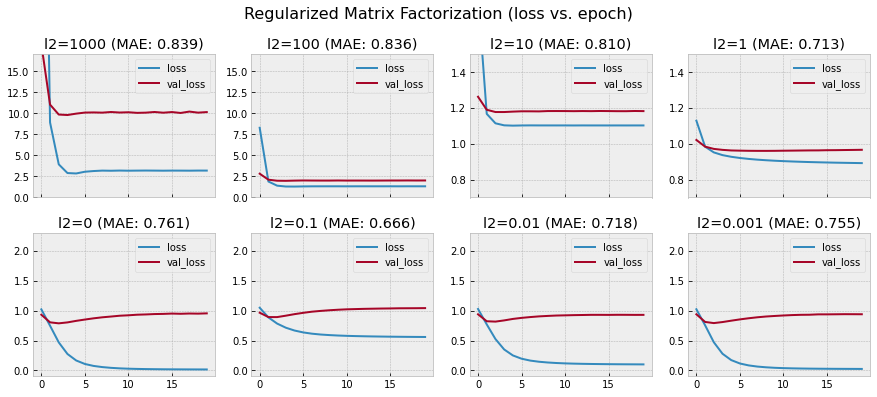

In [26]:
fig, axes = plt.subplots(2, 4, sharex=True, figsize=(15,6))
fig.suptitle("Regularized Matrix Factorization (loss vs. epoch)", fontsize=16)

for i, (k, v) in enumerate(hist_upper.items()):
    axes[0][i].plot(v.history['loss'], label='loss')
    axes[0][i].plot(v.history['val_loss'], label='val_loss')
    axes[0][i].set_title(k)
    axes[0][i].set_ylim([0, 17])
    axes[0][i].legend()

for i, (k, v) in enumerate(hist_lower.items()):
    axes[1][i].plot(v.history['loss'], label='loss')
    axes[1][i].plot(v.history['val_loss'], label='val_loss')
    axes[1][i].set_title(k)
    axes[1][i].set_ylim([-0.1, 2.3])
    axes[1][i].legend()

axes[0][2].set_ylim([0.7, 1.5])
axes[0][3].set_ylim([0.7, 1.5])
    
plt.subplots_adjust(wspace=0.2, hspace=0.25, top=0.87)
plt.show()